# Explore Raw Data Stored in a Single TFRecord File

Sources used as reference to create this jupyter notebook:
- https://github.com/waymo-research/waymo-open-dataset
- https://github.com/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial.ipynb
- https://github.com/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial_local.ipynb
- https://www.datafied.world/waymo-open-dataset-part-0-exploratory-data-analysis-76
- https://github.com/Jossome/Waymo-open-dataset-document

## Third Party License

This code has beed derived from tutorials in <cite>waymo-open-dataset</cite> repository, which (excluding third_party) is licensed under the [Apache License, Version 2.0](./LICENSE_WAYMO-OPEN-DATASET-TUTORIALS). Code appearing in third_party is licensed under terms appearing therein.

The Waymo Open Dataset itself is licensed under separate terms. Please visit https://waymo.com/open/terms/ for details. Code located at third_party/camera is licensed under a BSD 3-clause copyright license + an additional limited patent license applicable only when the code is used to process data from the Waymo Open Dataset as authorized by and in compliance with the Waymo Dataset License Agreement for Non-Commercial Use. See third_party/camera for details.

## Tree Structure of the Waymo Open Dataset stored in a TFRecord

Source: https://github.com/Jossome/Waymo-open-dataset-document

```
open_dataset
|-- LaserName
|   |-- UNKNOWN
|   |-- TOP
|   |-- FRONT
|   |-- SIDE_LEFT
|   |-- SIDE_RIGHT
|   `-- REAR
|-- CameraName
|   |-- UNKNOWN
|   |-- FRONT
|   |-- FRONT_LEFT
|   |-- FRONT_RIGHT
|   |-- SIDE_LEFT
|   `-- SIDE_RIGHT
|-- RollingShutterReadOutDirection
|   |-- UNKNOWN
|   |-- TOP_TO_BOTTOM
|   |-- LEFT_TO_RIGHT
|   |-- BOTTOM_TO_TOP
|   |-- RIGHT_TO_LEFT
|   `-- GLOBAL_SHUTTER
|-- Frame
|   |-- images ⇒ list of CameraImage
|   |   |-- name (CameraName)
|   |   |-- image
|   |   |-- pose
|   |   |-- velocity (v_x, v_y, v_z, w_x, w_y, w_z)
|   |   |-- pose_timestamp
|   |   |-- shutter
|   |   |-- camera_trigger_time
|   |   `-- camera_readout_done_time
|   |-- Context
|   |   |-- name
|   |   |-- camera_calibrations ⇒ list of CameraCalibration
|   |   |   |-- name
|   |   |   |-- intrinsic
|   |   |   |-- extrinsic
|   |   |   |-- width
|   |   |   |-- height
|   |   |   `-- rolling_shutter_direction (RollingShutterReadOutDirection)
|   |   |-- laser_calibrations ⇒ list of LaserCalibration
|   |   |   |-- name
|   |   |   |-- beam_inclinations
|   |   |   |-- beam_inclination_min
|   |   |   |-- beam_inclination_max
|   |   |   `-- extrinsic
|   |   `-- Stats
|   |       |-- laser_object_counts
|   |       |-- camera_object_counts
|   |       |-- time_of_day
|   |       |-- location
|   |       `-- weather
|   |-- timestamp_micros
|   |-- pose
|   |-- lasers ⇒ list of Laser
|   |   |-- name (LaserName)
|   |   |-- ri_return1 (RangeImage class)
|   |   |   |-- range_image_compressed
|   |   |   |-- camera_projection_compressed
|   |   |   |-- range_image_pose_compressed
|   |   |   `-- range_image
|   |   `-- ri_return2 (same as ri_return1)
|   |-- laser_labels ⇒ list of Label
|   |-- projected_lidar_labels (same as camera_labels)
|   |-- camera_labels ⇒ list of CameraLabels
|   |   |-- name (CameraName)
|   |   `-- labels ⇒ list of Label
|   `-- no_label_zones (Refer to the doc)
`-- Label
    |-- Box
    |   |-- center_x
    |   |-- center_y
    |   |-- center_z
    |   |-- length
    |   |-- width
    |   |-- height
    |   `-- heading
    |-- Metadata
    |   |-- speed_x
    |   |-- speed_y
    |   |-- accel_x
    |   `-- accel_y
    |-- type
    |-- id
    |-- detection_difficulty_level
    `-- tracking_difficulty_level
```

In [ ]:
# !pip3 install waymo-open-dataset

In [1]:
import os
import tensorflow as tf
import math
import numpy as np
import itertools
import pandas as pd

import matplotlib.pyplot as plt
#Used for creating the bouding boxes
import matplotlib.patches as patches

# Enable TensorFlow eager execution mode
tf.compat.v1.enable_eager_execution()

# Import waymoe open dataset utils
from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

In [2]:
%matplotlib inline

## Load Data Set from Selected TFRecord File

In [3]:
#tfrecord_filename = "../data/waymo/raw/segment-10241508783381919015_2889_360_2909_360_with_camera_labels.tfrecord"
tfrecord_filename = "../data/waymo/raw/segment-10017090168044687777_6380_000_6400_000_with_camera_labels.tfrecord"

# Load data set from tfrecord file
dataset = tf.data.TFRecordDataset(tfrecord_filename, compression_type='')

In [4]:
# loop over all frames in the data set and count the number of frames in tfrecord file
for cnt, data in enumerate(dataset):
    frame = open_dataset.Frame()
    #print(cnt)
num_of_frames_in_tfrecord = cnt + 1
print("tfrecord file: {}".format(tfrecord_filename))
print("number of frames: {}".format(cnt+1))

tfrecord file: ../data/waymo/raw/segment-10017090168044687777_6380_000_6400_000_with_camera_labels.tfrecord
number of frames: 198


## Read a Single Frame from the Data Set

In [5]:
for data in dataset:
    # read a single frame
    frame = open_dataset.Frame()
    # convert the byte array to numpy dictionary
    frame.ParseFromString(bytearray(data.numpy()))
    break

### Examine frame context

Refer to [dataset.proto](https://github.com/waymo-research/waymo-open-dataset/blob/master/waymo_open_dataset/dataset.proto) for the data format. The context contains shared information among all frames in the scene.

In [6]:
# print frame context information
print(frame.context)

name: "10017090168044687777_6380_000_6400_000"
camera_calibrations {
  name: FRONT
  intrinsic: 2059.612011552946
  intrinsic: 2059.612011552946
  intrinsic: 952.4121898799498
  intrinsic: 634.5872082485005
  intrinsic: 0.03545287376426267
  intrinsic: -0.33830085391165776
  intrinsic: 1.9229596190070855e-05
  intrinsic: 0.0007138551068011635
  intrinsic: 0.0
  extrinsic {
    transform: 0.9999785086634438
    transform: 0.003142074430868787
    transform: 0.005754092413724721
    transform: 1.5391467608686606
    transform: -0.0032444997400664865
    transform: 0.999834903267396
    transform: 0.017878462733512377
    transform: -0.02402951085443307
    transform: -0.005696966971249904
    transform: -0.017896747652793314
    transform: 0.9998236099386635
    transform: 2.115778469674332
    transform: 0.0
    transform: 0.0
    transform: 0.0
    transform: 1.0
  }
  width: 1920
  height: 1280
  rolling_shutter_direction: LEFT_TO_RIGHT
}
camera_calibrations {
  name: FRONT_LEFT
  int

In [7]:
# print information on frame context statistics
print(frame.context.stats)

laser_object_counts {
  type: TYPE_VEHICLE
  count: 7
}
laser_object_counts {
  type: TYPE_SIGN
  count: 9
}
time_of_day: "Day"
location: "location_sf"
weather: "sunny"
camera_object_counts {
  type: TYPE_VEHICLE
  count: 7
}



### Examine Instantaneous Ego Vehicle Velocities

Source: https://github.com/Jossome/Waymo-open-dataset-document

Camera images are given by frame.images. It's an iterable of images, indicating different camera positions: front, front left, front right, side left, side right. Each element has an attribute .name telling the name of its camera. The camera names are stored as constants in the open_dataset package (similar to macro):

```
open_dataset.CameraName.UNKNOWN     = 0
open_dataset.CameraName.FRONT       = 1
open_dataset.CameraName.FRONT_LEFT  = 2
open_dataset.CameraName.FRONT_RIGHT = 3
open_dataset.CameraName.SIDE_LEFT   = 4
open_dataset.CameraName.SIDE_RIGHT  = 5
```

In [8]:
for index, image in enumerate(frame.images):
    # look at front camera only
    if image.name == 1:
        print("image.name: \n{}".format(image.name))
        print("image.pose: \n{}".format(image.pose))
        print("image.velocity: \n{}".format(image.velocity))
        print("image.pose_timestamp: \n{}".format(image.pose_timestamp))
        print("image.shutter: \n{}".format(image.shutter))
        print("image.camera_trigger_time: \n{}".format(image.camera_trigger_time))
        print("image.camera_readout_done_time: \n{}".format(image.camera_readout_done_time))

image.name: 
1
image.pose: 
transform: 0.9482868309813268
transform: -0.23495154098744556
transform: 0.213424130723349
transform: -1257.1832108376184
transform: 0.23309384241643172
transform: 0.9718527764008171
transform: 0.03419709972449725
transform: 10546.041682516148
transform: -0.21545149527198962
transform: 0.017319191368196336
transform: 0.9763609469839603
transform: 22.447
transform: 0.0
transform: 0.0
transform: 0.0
transform: 1.0

image.velocity: 
v_x: 5.765130996704102
v_y: 1.3712701797485352
v_z: -1.3291109800338745
w_x: -0.010016016662120819
w_y: -0.014922491274774075
w_z: 0.10547474026679993

image.pose_timestamp: 
1550083467.40108
image.shutter: 
0.009991643950343132
image.camera_trigger_time: 
1550083467.369629
image.camera_readout_done_time: 
1550083467.423879


### Visualize Raw Mono Camera Images

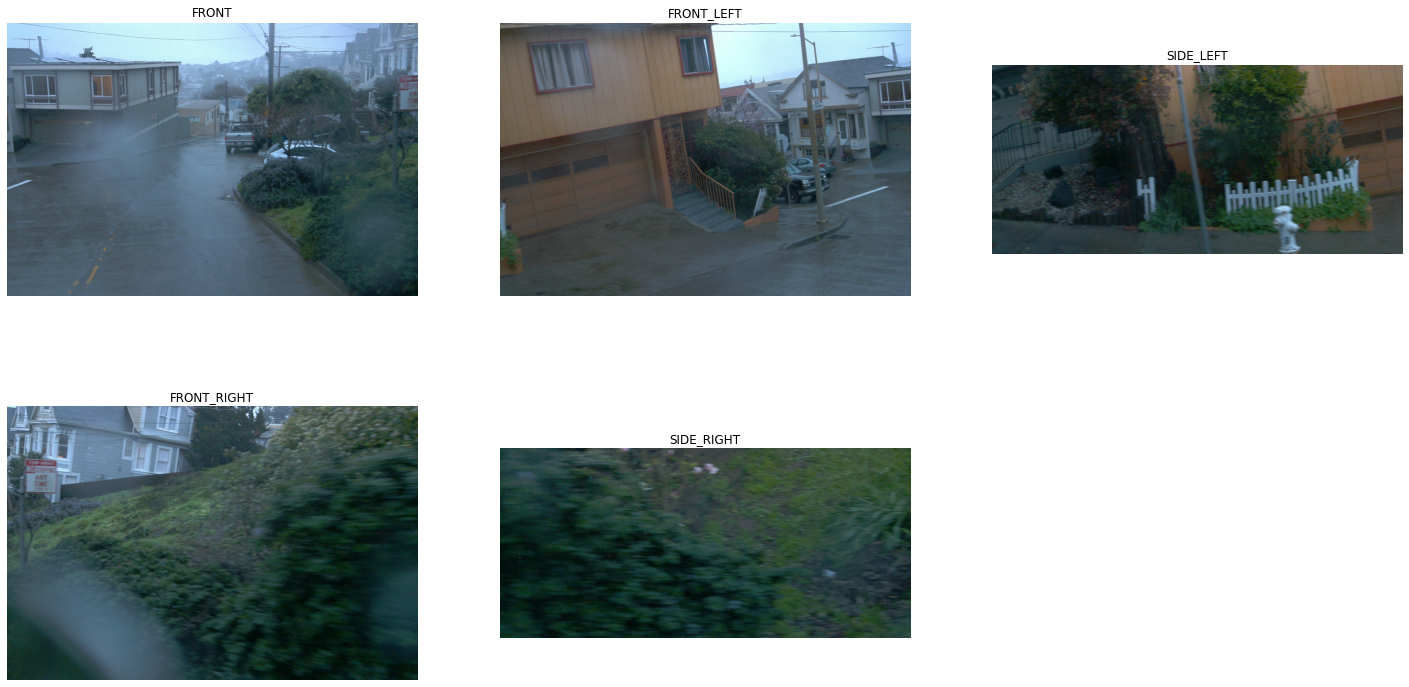

In [9]:
plt.figure(figsize=(25, 20))

def image_show(data, name, layout, cmap=None):
  """Show an image."""
  plt.subplot(*layout)
  plt.imshow(tf.image.decode_jpeg(data), cmap=cmap)
  plt.title(name)
  plt.grid(False)
  plt.axis('off')

for index, image in enumerate(frame.images):
  image_show(image.image, open_dataset.CameraName.Name.Name(image.name),
             [3, 3, index+1])

### Get the Ground Truth Object Labels for Mono Camera Images

In [10]:
print(frame.camera_labels)

[name: FRONT
labels {
  box {
    center_x: 1466.5519800000002
    center_y: 492.6402
    width: 109.89666
    length: 240.63579000000004
  }
  type: TYPE_VEHICLE
  id: "12ba81ee-9cee-4134-94ca-df9ed01e0ff1"
}
labels {
  box {
    center_x: 1109.07204
    center_y: 536.8515
    width: 156.00273000000004
    length: 178.73997000000008
  }
  type: TYPE_VEHICLE
  id: "2ab9ff55-a510-435b-a729-884444e67249"
}
labels {
  box {
    center_x: 1181.70489
    center_y: 519.16698
    width: 95.37008999999995
    length: 61.89581999999996
  }
  type: TYPE_VEHICLE
  id: "470e3826-ecd2-425c-80ca-33f3d8c876a6"
}
labels {
  box {
    center_x: 1006.1228699999999
    center_y: 486.95588999999995
    width: 39.15857999999997
    length: 28.421550000000025
  }
  type: TYPE_VEHICLE
  id: "98fcf17a-d19e-4c3b-bbc0-54ae2d1fcc15"
}
labels {
  box {
    center_x: 1380.02415
    center_y: 603.8000400000001
    width: 127.58118000000002
    length: 361.26947999999993
  }
  type: TYPE_VEHICLE
  id: "fb06fe05-95ee

## Visualize Mono Camera Images with Ground Truth Object Bounding Boxes

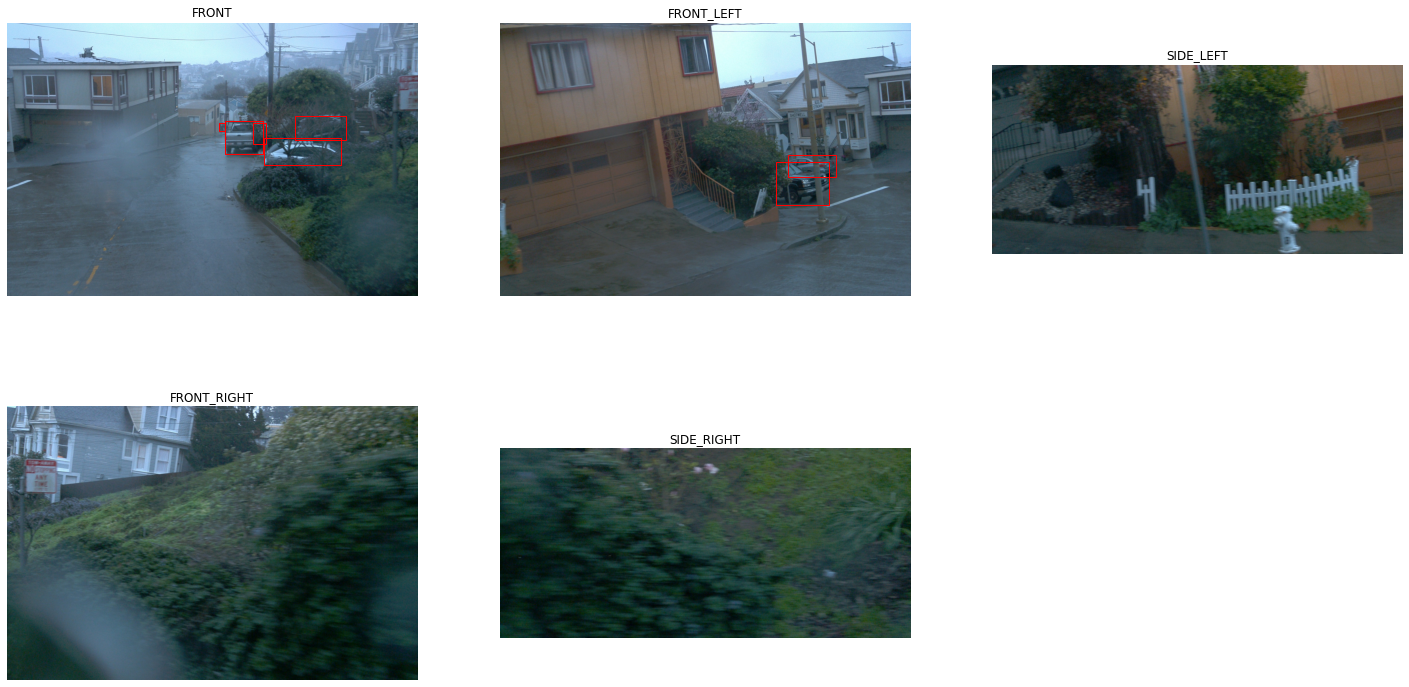

In [11]:
def show_camera_image(camera_image, camera_labels, layout, cmap=None):
  """Show a camera image and the given camera labels."""

  ax = plt.subplot(*layout)

  # Draw the camera labels.
  for camera_labels in frame.camera_labels:
    # Ignore camera labels that do not correspond to this camera.
    if camera_labels.name != camera_image.name:
      continue

    # Iterate over the individual labels.
    for label in camera_labels.labels:
      # Draw the object bounding box.
      ax.add_patch(patches.Rectangle(
        xy=(label.box.center_x - 0.5 * label.box.length,
            label.box.center_y - 0.5 * label.box.width),
        width=label.box.length,
        height=label.box.width,
        linewidth=1,
        edgecolor='red',
        facecolor='none'))

  # Show the camera image.
  plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
  plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
  plt.grid(False)
  plt.axis('off')

# show images of all cameras stored in the current frame
plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
  show_camera_image(image, frame.camera_labels, [3, 3, index+1])

## Visualize Range Images

In [12]:
# read range images, camera projections and range image top pose
(range_images, camera_projections,
 range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(
    frame)

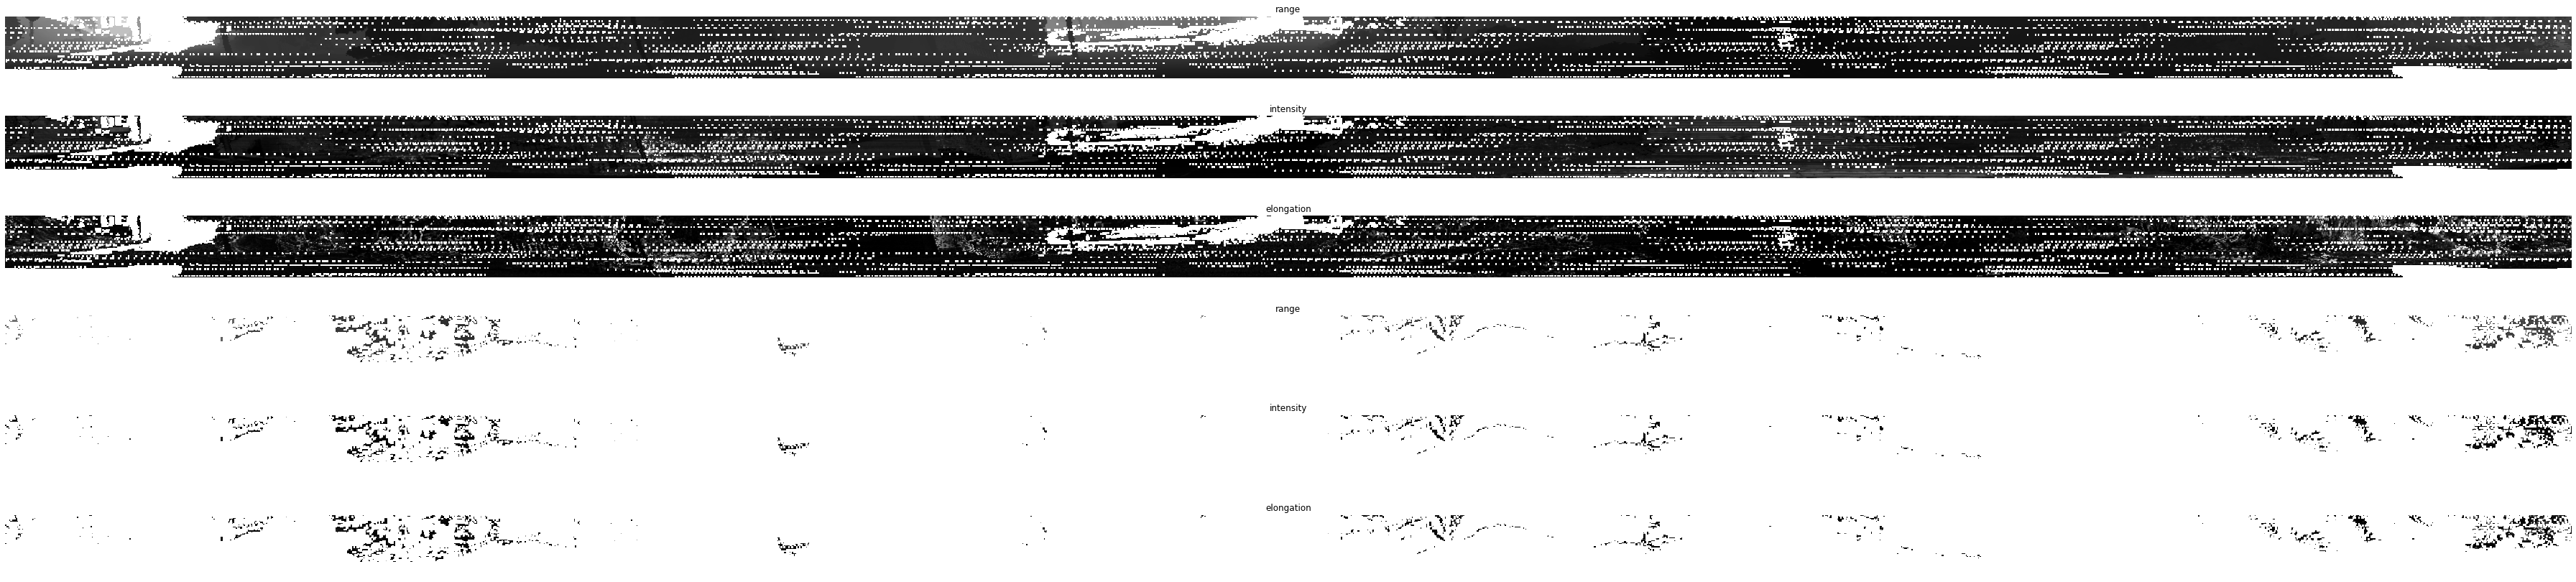

In [13]:
plt.figure(figsize=(64, 20))

def plot_range_image_helper(data, name, layout, vmin = 0, vmax=1, cmap='gray'):
  """Plots range image.

  Args:
    data: range image data
    name: the image title
    layout: plt layout
    vmin: minimum value of the passed data
    vmax: maximum value of the passed data
    cmap: color map
  """
  plt.subplot(*layout)
  plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.title(name)
  plt.grid(False)
  plt.axis('off')

def get_range_image(laser_name, return_index):
  """Returns range image given a laser name and its return index."""
  return range_images[laser_name][return_index]

def show_range_image(range_image, layout_index_start = 1):
  """Shows range image.

  Args:
    range_image: the range image data from a given lidar of type MatrixFloat.
    layout_index_start: layout offset
  """
  range_image_tensor = tf.convert_to_tensor(range_image.data)
  range_image_tensor = tf.reshape(range_image_tensor, range_image.shape.dims)
  lidar_image_mask = tf.greater_equal(range_image_tensor, 0)
  range_image_tensor = tf.where(lidar_image_mask, range_image_tensor,
                                tf.ones_like(range_image_tensor) * 1e10)
  range_image_range = range_image_tensor[...,0] 
  range_image_intensity = range_image_tensor[...,1]
  range_image_elongation = range_image_tensor[...,2]
  plot_range_image_helper(range_image_range.numpy(), 'range',
                   [8, 1, layout_index_start], vmax=75, cmap='gray')
  plot_range_image_helper(range_image_intensity.numpy(), 'intensity',
                   [8, 1, layout_index_start + 1], vmax=1.5, cmap='gray')
  plot_range_image_helper(range_image_elongation.numpy(), 'elongation',
                   [8, 1, layout_index_start + 2], vmax=1.5, cmap='gray')

# show range images stored in the current frame
frame.lasers.sort(key=lambda laser: laser.name)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 0), 1)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 1), 4)

## Point Cloud Conversion and Visualization

In [14]:
points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)
points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose,
    ri_index=1)

# 3d points in vehicle frame.
points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
# camera projection corresponding to each point.
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

### Examine number of points in each lidar sensor.

In [15]:
# first return
print(points_all.shape)
print(cp_points_all.shape)
print(points_all[0:2])
for i in range(5):
  print(points[i].shape)
  print(cp_points[i].shape)

(171606, 3)
(171606, 6)
[[-1.9172729e+01 -6.5429688e-02  2.9199677e+00]
 [-1.7224243e+01 -1.5625000e-02  2.8512268e+00]]
(153830, 3)
(153830, 6)
(3844, 3)
(3844, 6)
(3894, 3)
(3894, 6)
(4794, 3)
(4794, 6)
(5244, 3)
(5244, 6)


In [16]:
# second return
print(points_all_ri2.shape)
print(cp_points_all_ri2.shape)
print(points_all_ri2[0:2])
for i in range(5):
  print(points_ri2[i].shape)
  print(cp_points_ri2[i].shape)

(12074, 3)
(12074, 6)
[[-1.9289551e+01 -1.7578125e-02  2.9239807e+00]
 [-1.9253906e+01  3.7304688e-01  2.9273758e+00]]
(11340, 3)
(11340, 6)
(40, 3)
(40, 6)
(131, 3)
(131, 6)
(117, 3)
(117, 6)
(446, 3)
(446, 6)


## Visualize Camera Projection

In [17]:
images = sorted(frame.images, key=lambda i:i.name)
cp_points_all_concat = np.concatenate([cp_points_all, points_all], axis=-1)
cp_points_all_concat_tensor = tf.constant(cp_points_all_concat)

# The distance between lidar points and vehicle frame origin.
points_all_tensor = tf.norm(points_all, axis=-1, keepdims=True)
cp_points_all_tensor = tf.constant(cp_points_all, dtype=tf.int32)

mask = tf.equal(cp_points_all_tensor[..., 0], images[0].name)

cp_points_all_tensor = tf.cast(tf.gather_nd(
    cp_points_all_tensor, tf.where(mask)), dtype=tf.float32)
points_all_tensor = tf.gather_nd(points_all_tensor, tf.where(mask))

projected_points_all_from_raw_data = tf.concat(
    [cp_points_all_tensor[..., 1:3], points_all_tensor], axis=-1).numpy()

In [18]:
def rgba(r):
  """Generates a color based on range.

  Args:
    r: the range value of a given point.
  Returns:
    The color for a given range
  """
  c = plt.get_cmap('jet')((r % 20.0) / 20.0)
  c = list(c)
  c[-1] = 0.5  # alpha
  return c

def plot_image(camera_image):
  """Plot a cmaera image."""
  plt.figure(figsize=(20, 12))
  plt.imshow(tf.image.decode_jpeg(camera_image.image))
  plt.grid("off")

def plot_points_on_image(projected_points, camera_image, rgba_func,
                         point_size=5.0):
  """Plots points on a camera image.

  Args:
    projected_points: [N, 3] numpy array. The inner dims are
      [camera_x, camera_y, range].
    camera_image: jpeg encoded camera image.
    rgba_func: a function that generates a color from a range value.
    point_size: the point size.

  """
  plot_image(camera_image)

  xs = []
  ys = []
  colors = []

  for point in projected_points:
    xs.append(point[0])  # width, col
    ys.append(point[1])  # height, row
    colors.append(rgba_func(point[2]))

  plt.scatter(xs, ys, c=colors, s=point_size, edgecolors="none")

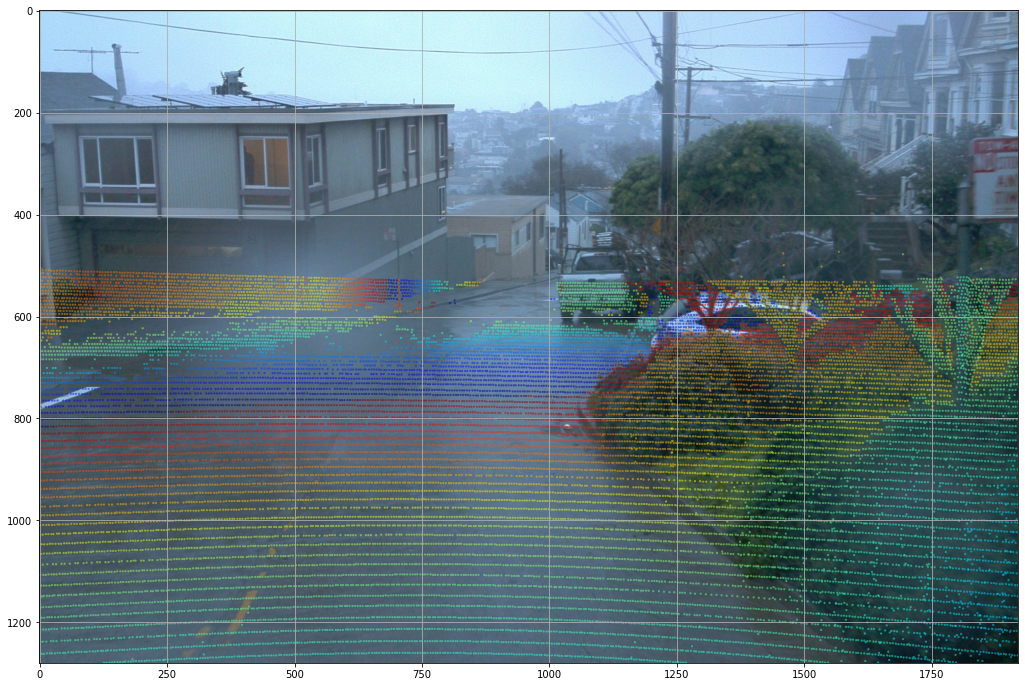

In [19]:
plot_points_on_image(projected_points_all_from_raw_data,
                     images[0], rgba, point_size=5.0)